In [1]:
import json
import pandas as pd
from collections import Counter
from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer()

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Read Tweets and Meta Data

In [2]:
tweet_json_file = "./data/all_tweets_with_meta.json"
with open(tweet_json_file, 'r') as f:
    long_tweets = json.load(f)

In [3]:
tweets = []
for tweet in long_tweets:
    tweets.append({
        'created_at': tweet['created_at'], 
        'text': tweet['text'],
        'in_reply_to_user_id': tweet['in_reply_to_screen_name'],
        'user': tweet['user']['screen_name'].lower(), 
        'favorite_count': tweet['favorite_count'],
        'retweet_count': tweet['retweet_count']})

# Read Candidate Relations

In [4]:
candidate_jsonlist_file = "./2014_us_gubernatorial_election_candidates_with_twitter.jsonlist"
candidates = []
with open(candidate_jsonlist_file, 'r') as f:
    for line in f:
        candidates.append(json.loads(line))

## Build Opponent Relationship

In [5]:
state_to_candidates = {}
for c in candidates:
    state = c['state']
    if state not in state_to_candidates:
        state_to_candidates[state] = set()
    state_to_candidates[state].add((c['name'].lower(), c['twitter'].lower()))

In [6]:
opponents = {}

# candidate relationship
for c in candidates:
    # key in by twitter handle
    t = c['twitter'].lower()
    if not t:
        continue
    if t not in opponents:
        opponents[t] = set()
        
    state_wide_opponents = state_to_candidates[c['state']]
    for name, twitter in state_wide_opponents:
        if twitter == t:
            continue
        if not twitter:
            continue
        
        opponents[t].add("@" + twitter.lower())
        for name_component in name.split():
            if name_component:
                opponents[t].add(name_component.lower())

# Attack Tweets

In [7]:
attacking = []
for tweet in tweets:
    user = tweet['user']
    oppo = opponents[user]
    text = tweet['text']
    
    tokenzied = tokenizer.tokenize(text)
    tokenzied = [token.lower() for token in tokenzied]
    attacking.append(any([o in tokenzied for o in oppo]) or "opponent" in tokenzied)
    
print("{0:.2f}% of tweets are attack tweets".format(100 * attacking.count(True) / len(attacking)))

11.62% of tweets are attack tweets


In [8]:
# get index of these attack tweets
attacking_index = [i for i, a in enumerate(attacking) if a]

In [9]:
for ai in attacking_index[10:20]:
    tweet = tweets[ai]
    user = tweet['user']
    oppo = opponents[user]
    text = tweet['text']
    
    print(text)
    print(oppo)
    print()

CRIST VS. SCOTT—FLORIDA CATFIGHT ROUND 3. COMEDY OR TRAGEDY? 

Last night’s “debate” on CNN would have been... http://t.co/OISjlchZvY
{'adrian', '@charliecrist', '@glennburkett4fl', 'rick', 'charlie', 'wyllie', '@scottforflorida', 'glenn', '@wyllieforgov', 'burkett', 'scott', 'crist'}

I have many other common sense positions that the Mr. Mead could adopt. How about removing his censor of science standards. #HelptheGov
{'@meadforgovernor', 'mead', 'matt'}

.@WSJ: Prosecutors are looking at whether Cuomo directed the Moreland Commission not to refer cases for prosecution http://t.co/dPsNk5k3ul
{'andrew', '@votemcdermott', '@howiehawkins', 'cuomo', 'michael', '@nygovcuomo', 'hawkins', 'mcdermott', 'howie'}

The election for Texas Governor is in 3 months. Don't let Obama &amp; Wendy Davis hijack Texas. Donate $20.14 --&gt; http://t.co/yEFbdeEmZF
{'wendy', 'glass', '@kathieglass4tx', 'kathie', 'davis', '@wendydavis'}

While Michiganders struggle to make ends meet, @onetoughnerd officials s

# Merge Dataset

## + Attacking

In [10]:
for tweet, is_attack in zip(tweets, attacking):
    tweet['is_attack'] = is_attack

## + Geography

In [11]:
candidate_to_state = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_state[t] = c['state']
        
for tweet in tweets:
    tweet['state'] = candidate_to_state[tweet['user']]

## + Party

In [12]:
candidate_to_party = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_party[t] = c['party']
        
for tweet in tweets:
    tweet['party'] = candidate_to_party[tweet['user']]

## + Incumbency

In [13]:
candidate_to_incumbency = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_incumbency[t] = c['incumbency']
        
for tweet in tweets:
    tweet['incumbency'] = candidate_to_incumbency[tweet['user']]

## + Competitiveness
Needs to + States first

In [14]:
with open("./competitiveness.jsonlist", 'r') as f:
    state_to_competitiveness = json.load(f)

for tweet in tweets:
    state = tweet['state']
    tweet['competitiveness'] = state_to_competitiveness[state]

# Filter Out Penn Tweets

Pennsylvania seems like an outlier which has an extremely high percentage of attack tweets. By excluding it, we see results that conform to previous literture.

In [15]:
# tweets = [tweet for tweet in tweets if tweet['state'] != "Pennsylvania"]

# Attack By States

In [16]:
state_to_attack_count = Counter()
state_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    state = tweet['state']
    
    state_to_total_tweets[state] += 1
    
    if is_attack:
        state_to_attack_count[state] += 1

states = list(state_to_total_tweets.keys())        
rates = [state_to_attack_count[state] / state_to_total_tweets[state] for state in states]

df_attack_rate_by_state = pd.DataFrame(index=states, data=rates, columns=["attack_rate"])

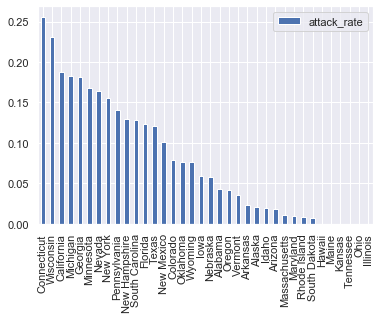

In [17]:
df_attack_rate_by_state.sort_values("attack_rate", ascending=False).plot.bar()

# Attack By Party

In [18]:
party_to_attack_count = Counter()
party_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    party = tweet['party']
    
    party_to_total_tweets[party] += 1
    
    if is_attack:
        party_to_attack_count[party] += 1

parties = list(party_to_total_tweets.keys())        
rates = [party_to_attack_count[party] / party_to_total_tweets[party] for party in parties]

df_attack_rate_by_party = pd.DataFrame(index=parties, data=rates, columns=["attack_rate"])

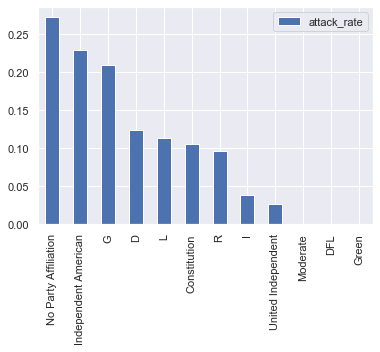

In [19]:
df_attack_rate_by_party.sort_values("attack_rate", ascending=False).plot.bar()

# Attack By Incumbency

In [20]:
incumbency_to_attack_count = Counter()
incumbency_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    incumbency = tweet['incumbency']
    
    incumbency_to_total_tweets[incumbency] += 1
    
    if is_attack:
        incumbency_to_attack_count[incumbency] += 1

incumbencies = list(incumbency_to_total_tweets.keys())        
rates = [incumbency_to_attack_count[incumbency] / incumbency_to_total_tweets[incumbency] for incumbency in incumbencies]

readable_i_mapping = {True: "Incumbent", 
                      False: "Challenger"}

readable_i = [readable_i_mapping[i] for i in incumbencies]
df_attack_rate_by_incumbency = pd.DataFrame(index=readable_i, data=rates, columns=["attack_rate"])

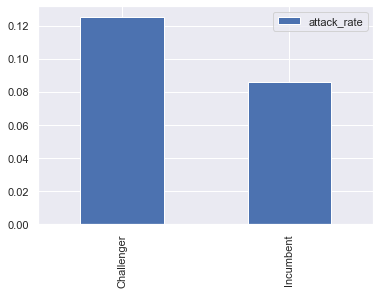

In [21]:
df_attack_rate_by_incumbency.sort_values("attack_rate", ascending=False).plot.bar()

# Attack By Competitiveness

In [22]:
competitiveness_to_attack_count = Counter()
competitiveness_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    competitiveness = tweet['competitiveness']
    
    competitiveness_to_total_tweets[competitiveness] += 1
    
    if is_attack:
        competitiveness_to_attack_count[competitiveness] += 1

competitivenesses = list(competitiveness_to_total_tweets.keys())        
rates = [competitiveness_to_attack_count[competitiveness] / competitiveness_to_total_tweets[competitiveness] for competitiveness in competitivenesses]

readable_c_mapping = {True: "Competitive", 
                      False: "Non-competitive"}

readable_c = [readable_c_mapping[c] for c in competitivenesses]

df_attack_rate_by_competitiveness = pd.DataFrame(index=readable_c, data=rates, columns=["attack_rate"])

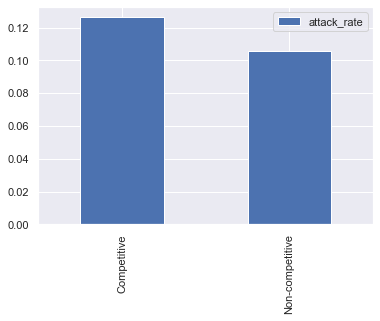

In [23]:
df_attack_rate_by_competitiveness.sort_values("attack_rate", ascending=False).plot.bar()

# Attack by Joint (Competiveness, Incumbency)

In [24]:
ci_to_attack_count = Counter()
ci_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    competitiveness = tweet['competitiveness']
    incumbency = tweet['incumbency']
    
    ci_to_total_tweets[(competitiveness, incumbency)] += 1
    
    if is_attack:
        ci_to_attack_count[(competitiveness, incumbency)] += 1

cies = list(ci_to_total_tweets.keys())        
rates = [ci_to_attack_count[ci] / ci_to_total_tweets[ci] for ci in cies]

readable_ci_mapping = {(True, True): ("Competitive", "Incumbent"), 
                      (True, False): ("Competitive", "Challenger"),
                      (False, True): ("Non-competitive", "Incumbent"),
                      (False, False): ("Non-competitive", "Challenger")}

readable_ci = [readable_ci_mapping[ci] for ci in cies]
df_attack_rate_by_ci = pd.DataFrame(index=readable_ci, data=rates, columns=["attack_rate"])

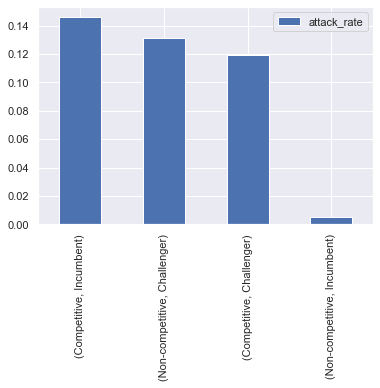

In [25]:
df_attack_rate_by_ci.sort_values("attack_rate", ascending=False).plot.bar()

# Distiguishing Ad Hominem Attacks

In [34]:
attack_tweet_texts = [tweets[ai]["text"] for ai in attacking_index]

In [41]:
attack_tweet_texts[20]

'@JadedByPolitics Wyllie at 14% in polls now and climbing. Floridians detest both Scott &amp; Crist. @Mrs__Met @OGwhiz'